In [55]:
pip install nnAudio

In [56]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [57]:
ls

gdrive/  model.png  sample_data/


In [58]:
import pandas as pd # Panel Data
import matplotlib.pyplot as plt # Make Grafics
from matplotlib.gridspec import GridSpec # Axes os Graphics
import numpy as np #Lineal Algebra
import warnings #Ignore Warnings
from random import shuffle
import tensorflow as tf #Model and Dataset
from sklearn.model_selection import train_test_split
from scipy import signal
warnings.filterwarnings("ignore")

train_labels = pd.read_csv('gdrive/MyDrive/Datos_Ligeros/training_labels.csv')
sample_submission = pd.read_csv('gdrive/MyDrive/Datos_Ligeros/sample_submission.csv')

In [59]:
train_labels

,id,target
0,00000e74ad,1
1,00001f4945,0
2,0000661522,0
3,00007a006a,0
4,0000a38978,1
...,...,...
559995,ffff9a5645,1
559996,ffffab0c27,0
559997,ffffcf161a,1
559998,ffffd2c403,0


In [60]:
sample_submission.head()

,id,target
0,00005bced6,0.5
1,0000806717,0.5
2,0000ef4fe1,0.5
3,00020de251,0.5
4,00024887b5,0.5


#Get the Path

In [61]:

def id2path(idx, is_train = True):
    path = "gdrive/MyDrive/Datos_Ligeros"

    if is_train:
        path += "/train3/" + idx[0] + "/" + idx[1] + "/" + idx[2] + "/" + idx + ".npy"

    else:
        path += "/test3/" + idx[0] + "/" + idx[1] + "/" + idx[2] + "/" + idx + ".npy"

    return path

In [62]:

def id2path(idx, is_train = True):
    path = "gdrive/MyDrive/Datos_Ligeros"

    if is_train:
        path += "/train/" + idx[0] + "/" + idx[1] + "/" + idx[2] + "/" + idx + ".npy"

    else:
        path += "/test/" + idx[0] + "/" + idx[1] + "/" + idx[2] + "/" + idx + ".npy"

    return path

#Increase Dimension whit Constant Q-Transform

Esta parte del codigo permite, manipular los datos como si fueran archivos de audio, esto con el fin de realizar una transformada de Fourier en escala logaritmica, para graficar la informacion de las bases de datos en espectrogramas.

In [63]:
from nnAudio.Spectrogram import CQT1992v2
import torch

def increase_dimension(idx, is_train, transform = CQT1992v2(sr = 2048, hop_length = 64, fmin = 20, fmax = 500)):
    wave = np.load(id2path(idx, is_train))
    wave = np.concatenate(wave, axis = 0)
    bHP, aHP = signal.butter(8, (20, 500), btype='bandpass', fs=2048)
    window = signal.tukey(4096*3, 0.2)
    wave *= window
    wave = signal.filtfilt(bHP, aHP, wave)
    wave = wave / np.max(wave)
    wave = torch.from_numpy(wave).float()
    image = transform(wave)
    image = np.array(image)
    image = np.transpose(image, (1, 2, 0))

    return image


CQT kernels created, time used = 0.1015 seconds


In [64]:
ls

gdrive/  model.png  sample_data/


#Visualizar los datos

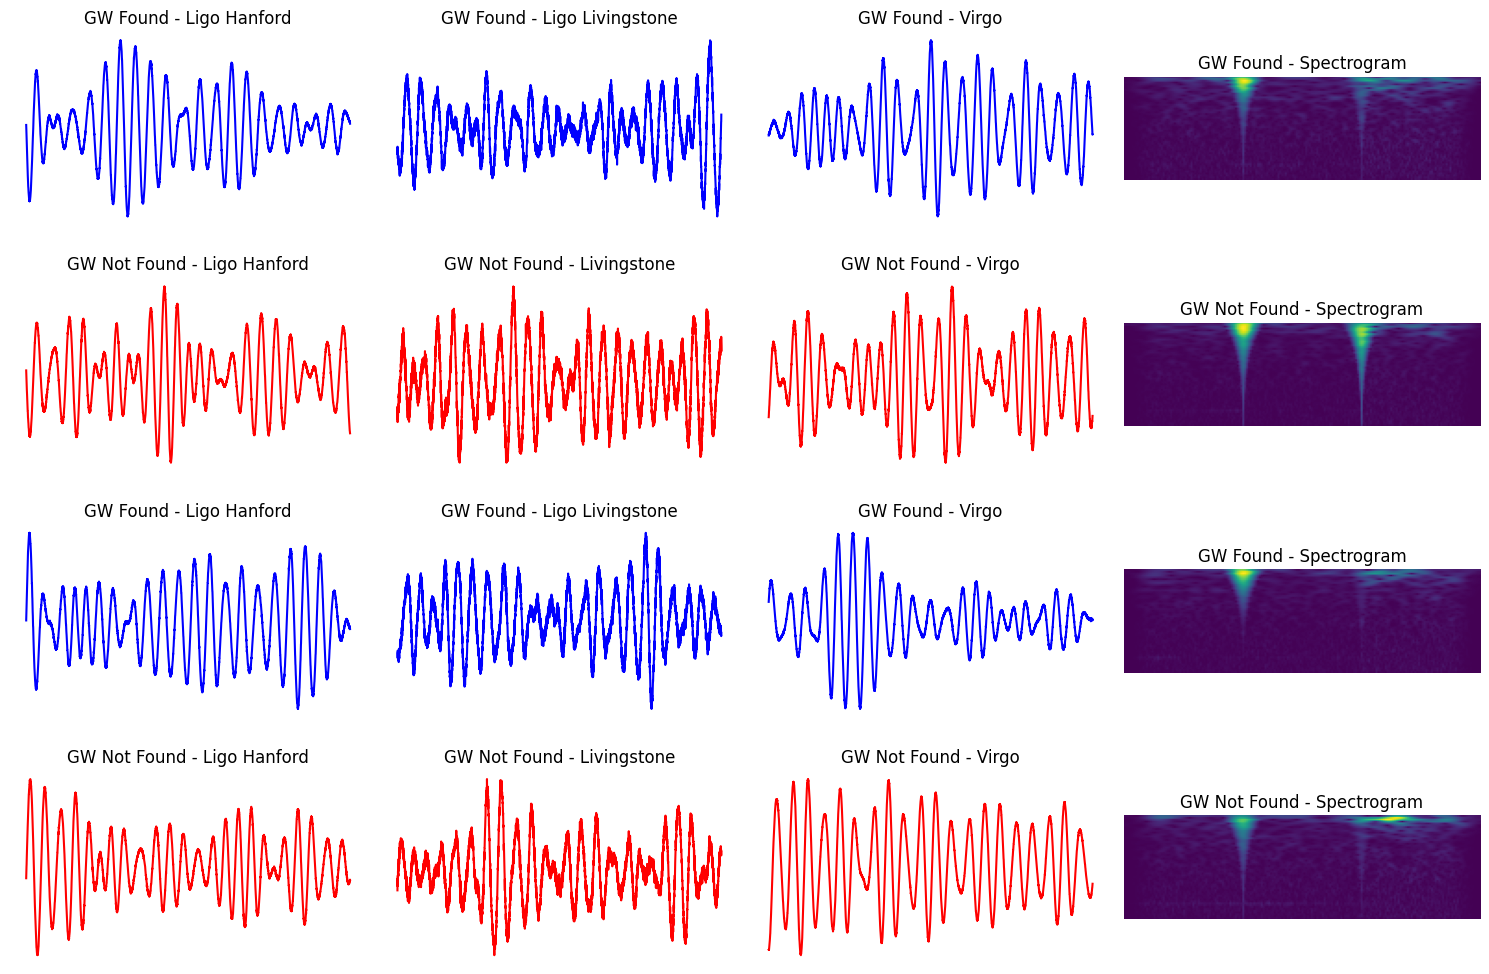

In [65]:
targets = train_labels[train_labels["target"] == 0]["id"].head(2)
no_targets = train_labels[train_labels["target"] == 1]["id"].head(2)
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(4, 4, figure=fig)

for i, (target, no_target) in enumerate(zip(targets, no_targets)):
    # Subplot para GW Found (gráfico de líneas)
    ax1 = fig.add_subplot(gs[i*2, 0])
    ax1.plot(np.load(id2path(target))[1, :], color='blue')
    ax1.set_title("GW Found - Ligo Hanford")
    ax1.set_axis_off()

    ax2 = fig.add_subplot(gs[i*2, 1])
    ax2.plot(np.load(id2path(target))[2, :], color='blue')
    ax2.set_title("GW Found - Ligo Livingstone")
    ax2.set_axis_off()

    ax3 = fig.add_subplot(gs[i*2, 2])
    ax3.plot(np.load(id2path(target))[0, :], color='blue')
    ax3.set_title("GW Found - Virgo")
    ax3.set_axis_off()

    ax4 = fig.add_subplot(gs[i*2, 3])
    ax4.imshow(increase_dimension(target, is_train=True))
    ax4.set_title("GW Found - Spectrogram")
    ax4.set_axis_off()


    # Subplot para GW Not Found (gráfico de líneas)
    ax5 = fig.add_subplot(gs[i*2 + 1, 0])
    ax5.plot(np.load(id2path(no_target))[1, :], color='red')
    ax5.set_title("GW Not Found - Ligo Hanford")
    ax5.set_axis_off()

    ax6 = fig.add_subplot(gs[i*2 + 1, 1])
    ax6.plot(np.load(id2path(no_target))[2, :], color='red')
    ax6.set_title("GW Not Found - Livingstone")
    ax6.set_axis_off()

    ax7 = fig.add_subplot(gs[i*2 + 1, 2])
    ax7.plot(np.load(id2path(no_target))[0, :], color='red')
    ax7.set_title("GW Not Found - Virgo")
    ax7.set_axis_off()

    ax8 = fig.add_subplot(gs[i*2 + 1, 3])
    ax8.imshow(increase_dimension(no_target, is_train=True))
    ax8.set_title("GW Not Found - Spectrogram")
    ax8.set_axis_off()

plt.tight_layout()
plt.show()

#Batch Data

In [66]:
import math
class Dataset(tf.keras.utils.Sequence):
    def __init__(self, data, y = None, batch_size = 256, shuffle = True):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle

        if y is not None:
            self.is_train = True
        else:
            self.is_train = False

        self.y = y

    def __len__(self):
        return math.ceil(len(self.data)/ self.batch_size)

    def __getitem__(self, ids):
        batch_data = self.data[ids * self.batch_size : (ids + 1) * self.batch_size]

        if self.y is not None:
            batch_y = self.y[ids * self.batch_size : (ids + 1) * self.batch_size]

        batch_x = np.array([increase_dimension(x, self.is_train) for x in batch_data])
        batch_x = np.stack(batch_x)

        if self.is_train:
            return batch_x, batch_y
        else:
            return batch_x

    def on_epoch_end(self):
        if self.shuffle and self.is_train:
            ids_y = list(zip(self.data, self.y))
            shuffle(ids_y)
            self.data, self.y = list(zip(*ids_y))


In [75]:

train_idx  = train_labels[train_labels["id"].str.startswith("00")]
train_idx = train_idx['id'].values
y = train_labels[train_labels["id"].str.startswith("00")]
y = y['target'].values
test_idx = sample_submission[sample_submission["id"].str.startswith("00")]
test_idx = test_idx['id'].values

print("train_idx shape: ", train_idx.shape)
print("train_idx: ", train_idx)
print("y shape: ", y.shape)
print("Y:",y )
print("test_idx shape: ", test_idx.shape)
print("test_idx: ", test_idx)


x_train,x_valid,y_train,y_valid = train_test_split(train_idx,y,test_size=0.05,random_state=42,stratify=y)

train_dataset = Dataset(x_train,y_train)
valid_dataset = Dataset(x_valid,y_valid)
test_dataset = Dataset(test_idx)



train_idx shape:  (2274,)
train_idx:  ['00000e74ad' '00001f4945' '0000661522' ... '00ffda0f3e' '00ffddc10e'
 '00ffe9278f']
y shape:  (2274,)
Y: [1 0 0 ... 0 1 1]
test_idx shape:  (840,)
test_idx:  ['00005bced6' '0000806717' '0000ef4fe1' '00020de251' '00024887b5'
 '0002b00931' '0003259f74' '000532d9b1' '00053de60c' '00055a3ff5'
 '00057291a8' '000607be1c' '0006453925' '000647cb6f' '0006b8c248'
 '0007eb08fa' '000807e4e4' '00087926bb' '00088396ac' '0008a42159'
 '0008c6a89e' '0008c7ecca' '00098cdd13' '0009c24747' '0009c4d0b8'
 '0009f3ec1f' '000a57c81d' '000a5bfbf4' '000a699e5e' '000a95138a'
 '000acb4ea4' '000b686e0e' '000bb9232a' '000bc770a9' '000bf5f26e'
 '000c0d1794' '000c2643db' '000c7866a9' '000cc7fc63' '000d3f8487'
 '000d8a31b7' '000d974265' '000dd04f30' '000ea761ad' '000f0a134c'
 '001045a53d' '0010564a1e' '0010665bcf' '0010a8cba0' '0010ca7d0e'
 '0011559b1d' '00116f25d1' '0011700aa2' '0011aa038d' '0011f9f93d'
 '00124588a3' '0012492ef7' '0012508531' '00129a0813' '00132bc714'
 '0013aebb2

In [68]:
pip install efficientnet

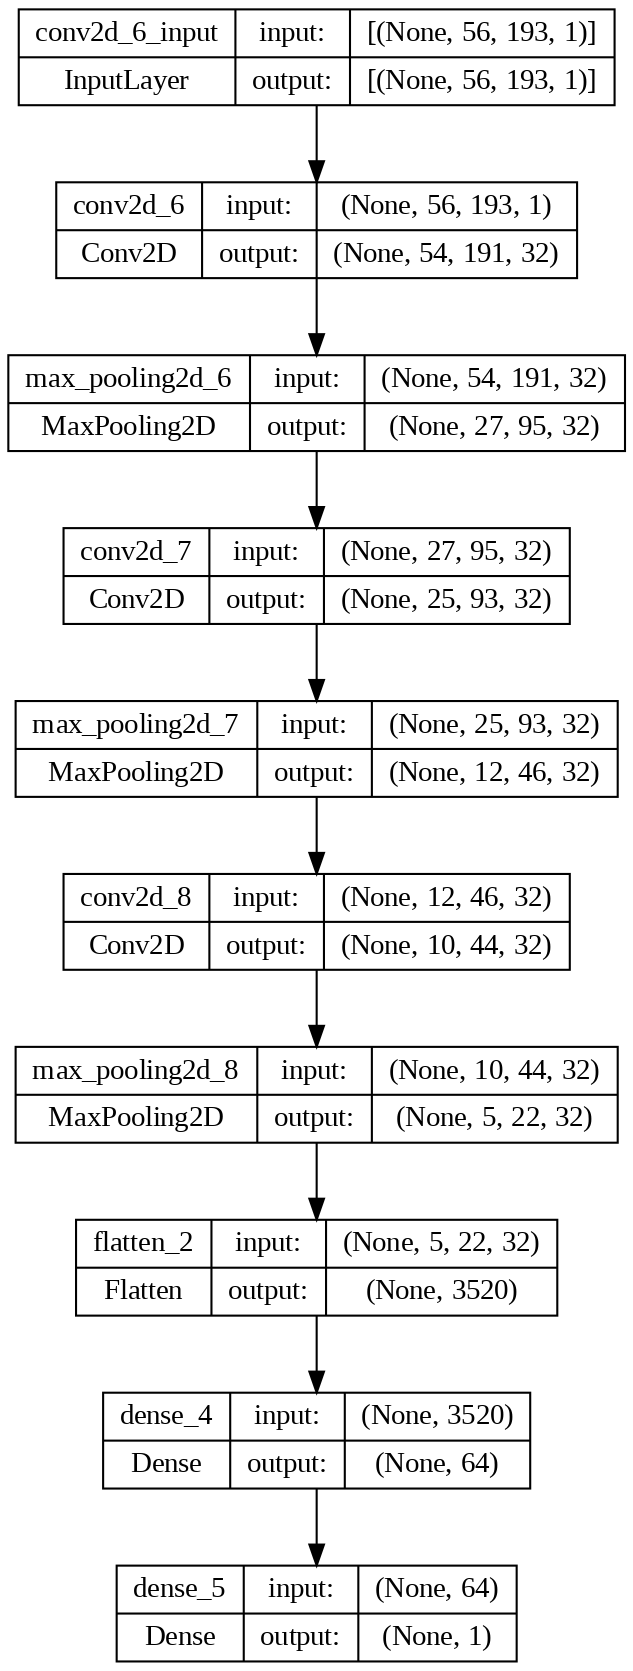

In [69]:
def create_model():
    Conv1 = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3) ,input_shape = [56, 193, 1], activation = "elu")
    Maxpooling1 = tf.keras.layers.MaxPool2D()
    Conv2 = tf.keras.layers.Conv2D(filters = 32,  kernel_size = (3, 3), activation = "elu")
    Maxpooling2 = tf.keras.layers.MaxPool2D()
    Conv3 = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = "elu")
    Maxpooling3 = tf.keras.layers.MaxPool2D()
    flatten = tf.keras.layers.Flatten()
    Dense1 = tf.keras.layers.Dense(64, activation = "relu")
    dense2 = tf.keras.layers.Dense(1, activation = "sigmoid")

    model = tf.keras.Sequential([Conv1, Maxpooling1,Conv2, Maxpooling2, Conv3, Maxpooling3, flatten ,Dense1, dense2])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

    return model

model = create_model()

from tensorflow.keras.utils import plot_model

# Definir el modelo aquí (igual que en el código anterior)

# Crear un objeto TensorBoard para visualizar el modelo
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')

# Entrenar el modelo con el objeto TensorBoard como argumento de callback
# model.fit(x_train, y_train, epochs=10, callbacks=[tensorboard_callback])

# Generar una imagen del diagrama de flujo del modelo
plot_model(model, to_file='model.png', show_shapes=True, dpi=150)


In [70]:
model.fit(train_dataset, epochs = 10, validation_data = valid_dataset)

Epoch 1/10
9/9 [==============================] - 69s 6s/step - loss: 0.6946 - auc_2: 0.5176 - val_loss: 0.6873 - val_auc_2: 0.6865
Epoch 2/10
9/9 [==============================] - 56s 6s/step - loss: 0.6893 - auc_2: 0.5558 - val_loss: 0.6805 - val_auc_2: 0.6925
Epoch 3/10
9/9 [==============================] - 55s 6s/step - loss: 0.6863 - auc_2: 0.5635 - val_loss: 0.6714 - val_auc_2: 0.7087
Epoch 4/10
9/9 [==============================] - 63s 7s/step - loss: 0.6709 - auc_2: 0.6338 - val_loss: 0.6490 - val_auc_2: 0.7250
Epoch 5/10
9/9 [==============================] - 53s 5s/step - loss: 0.6440 - auc_2: 0.6740 - val_loss: 0.6298 - val_auc_2: 0.7830
Epoch 6/10
9/9 [==============================] - 54s 6s/step - loss: 0.6181 - auc_2: 0.7049 - val_loss: 0.5741 - val_auc_2: 0.7872
Epoch 7/10
9/9 [==============================] - 52s 5s/step - loss: 0.5940 - auc_2: 0.7328 - val_loss: 0.5575 - val_auc_2: 0.8046
Epoch 8/10
9/9 [==============================] - 52s 6s/step - loss: 0.5616

In [76]:
# Cargar los pesos del modelo (si ya has entrenado el modelo)
# model.load_weights('ruta_del_archivo_de_pesos.h5')

# Evaluar el modelo en los datos de prueba
loss, auc = model.evaluate(valid_dataset)
print(f"Pérdida en datos de prueba: {loss:.4f}")
print(f"AUC en datos de prueba: {auc:.4f}")

# Obtener predicciones en los datos de prueba
predictions = model.predict(valid_dataset)

# Ajustar el umbral si es necesario (por ejemplo, para clasificación binaria)
# threshold = 0.5
# labels = (predictions > threshold).astype(int)
# print("Predicciones de etiquetas:", labels)


1/1 [==============================] - 2s 2s/step - loss: 0.5532 - auc_2: 0.7981
Pérdida en datos de prueba: 0.5532
AUC en datos de prueba: 0.7981
1/1 [==============================] - 2s 2s/step


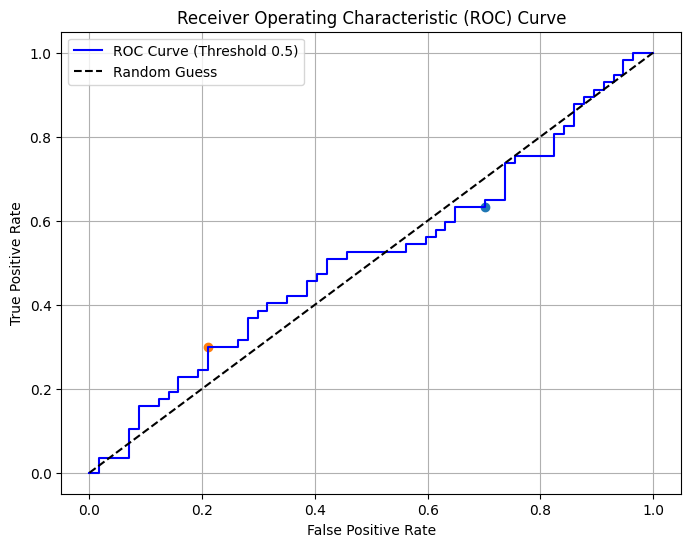

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc



# Calcular las tasas de verdaderos positivos y falsos positivos para diferentes umbrales
fpr, tpr, thresholds = roc_curve(y_valid, predictions)

# Graficar las curvas ROC para tres umbrales específicos
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (Threshold 0.5)', color='b')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

# Agregar curvas ROC para otros umbrales (por ejemplo, 0.3 y 0.7)
threshold_values = [0.3, 0.7]
for threshold in threshold_values:
    idx = np.argmin(np.abs(thresholds - threshold))
    plt.scatter(fpr[idx], tpr[idx], marker='o', label=f'Threshold {threshold:.1f}')

plt.grid(True)
plt.show()


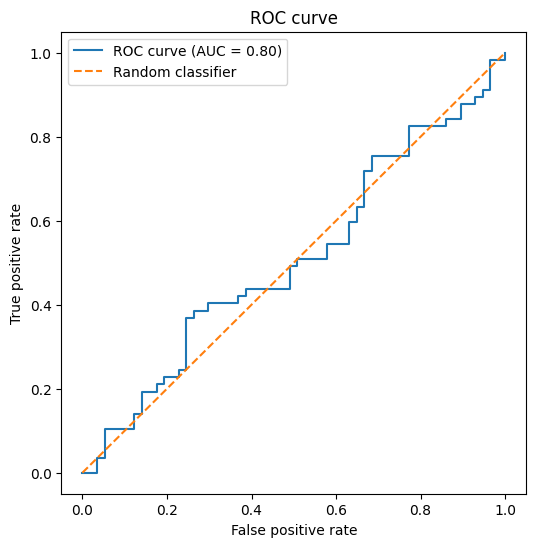

In [77]:
import sklearn.metrics

# Calcular los valores de TPR y FPR para diferentes umbrales
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_valid, predictions)

# Calcular el AUC



# Graficar la curva ROC
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.show()

Matriz de Confusión:
[[40 17]
 [36 21]]


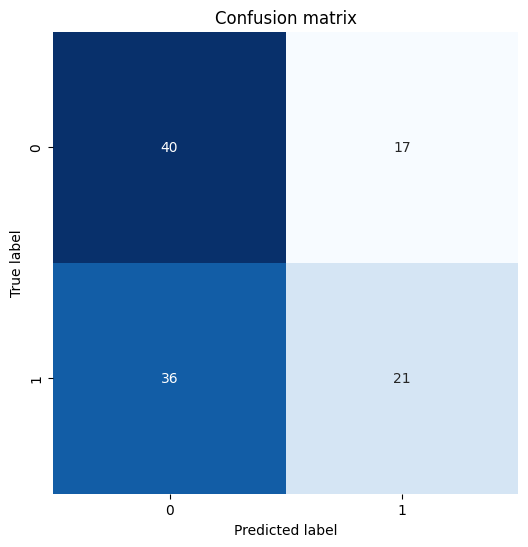

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns



# Ajustar el umbral si es necesario (por ejemplo, para clasificación binaria)
threshold = 0.5
labels = (predictions > threshold).astype(int)

# Calcular la matriz de confusión
cm = confusion_matrix(y_valid, labels)

# Imprimir la matriz de confusión
print("Matriz de Confusión:")
print(cm)

# Graficar la matriz de confusión
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()